# <font color=”darkblue”> Joint Calibration time-series data and option prices </font>

In [6]:
import signatory
import torch
#Call packages
import itertools as itt  
import iisignature
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import esig
import random
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from functools import partial
from bokeh.io import show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure, show
from bokeh.layouts import column
import pandas as pd
from sklearn.metrics import mean_squared_error 
from bokeh.embed import file_html
import chart_studio.plotly as py
import time as tm
from scipy.integrate import quad
from bokeh.models import Legend
import cmath
from math import isnan
from scipy.optimize import bisect, least_squares, minimize_scalar, minimize
from scipy.stats import norm
import os
from py_vollib.ref_python.black_scholes_merton.implied_volatility import implied_volatility
from py_vollib.ref_python.black_scholes_merton.implied_volatility import black_scholes_merton

In [7]:
output_notebook()

Loading BokehJS ...

### <font color=”darkblue”> Load some of the functions from the path calibration </font>

In [7]:
import path_calibration as pc
import stochastic_processes as sp

# <font color=”darkblue”> Regression on the price </font>

In [8]:
order_Signature=2
comp_of_path=3

x, y=pc.create_list_words_SV(order_Signature,comp_of_path)
print(y)
print(x)


[[], [1], [2], [3], [1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]
['()', '(1)', '(2)', '(3)', '(1,1)', '(1,2)', '(1,3)', '(2,1)', '(2,2)', '(2,3)', '(3,1)', '(3,2)', '(3,3)']


In [9]:
print('Example of transformation of the word [1,2,1] :',pc.tilde_transformation([1,2])) #All possible suffixes!
print('Example of transformation of the word [1,2,2] :',pc.tilde_transformation([1,1]))
print('Example of transformation of the word [1,2,3] :',pc.tilde_transformation([1,2,3]))


Example of transformation of the word [1,2,1] : ([1, 2, 2], [1, 2, 3], [1, 1])
Example of transformation of the word [1,2,2] : ([1, 1, 2], [1, 1, 3])
Example of transformation of the word [1,2,3] : ([1, 2, 3, 2], [1, 2, 3, 3], [1, 2, 1])


In [10]:
tilde = pc.e_tilde_part2_new(y) #Memo: run it only once otherwise it iterates the transformation as input constraints are still satisfied
#print(tilde)
new_tilde=pc.from_tilde_to_strings_new(tilde)
#print(new_tilde)

# <font color=”darkblue”> As follows some auxiliar function </font>

In [11]:
def duplicate(testList, n):
    x=[list(testList) for _ in range(n)]
    flat_list = []
    for sublist in x:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def Heston_P_Value(hestonParams,r,T,s0,K,typ):
    kappa, theta, sigma, rho, v0 = hestonParams
    return 0.5+(1./np.pi)*quad(lambda xi: Int_Function_1(xi,kappa,theta, sigma,rho,v0,r,T,s0,K,typ),0.,500.)[0]

def Int_Function_1(xi,kappa,theta,sigma,rho,v0,r,T,s0,K,typ):
    return (cmath.e**(-1j*xi*np.log(K))*Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ)/(1j*xi)).real

def Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ):
    if typ == 1:
        w = 1.
        b = kappa - rho*sigma
    else:
        w = -1.
        b = kappa
    ixi = 1j*xi
    d = cmath.sqrt((rho*sigma*ixi-b)*(rho*sigma*ixi-b) - sigma*sigma*(w*ixi-xi*xi))
    g = (b-rho*sigma*ixi-d) / (b-rho*sigma*ixi+d)
    ee = cmath.e**(-d*T)
    C = r*ixi*T + kappa*theta/(sigma*sigma)*((b-rho*sigma*ixi-d)*T - 2.*cmath.log((1.0-g*ee)/(1.-g)))
    D = ((b-rho*sigma*ixi-d)/(sigma*sigma))*(1.-ee)/(1.-g*ee)
    return cmath.e**(C + D*v0 + ixi*np.log(s0))

def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)

#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):   #S=F*DF
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF

#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

def heston_EuropeanCall(hestonParams,r,T,s0,K):
    a = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    return a-b

def heston_Vanilla(hestonParams,r,T,s0,K,flag):
    a_call = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b_call = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    a_put = s0*(1-Heston_P_Value(hestonParams,r,T,s0,K,1))
    b_put = K*np.exp(-r*T)*(1-Heston_P_Value(hestonParams,r,T,s0,K,2))
    if flag=='call':
        return a_call-b_call
    if flag=='put':
        return b_put-a_put
    else:
        return print('You have chosen a flag which is not a Vanilla Option')
    

def heston_Impliedvol(hestonParams,r,T,s0,K):
    myPrice = heston_EuropeanCall(hestonParams,r,T,s0,K)
    ## Bisection algorithm when the Lee-Li algorithm breaks down
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True, s0, K, T, r, 0., vol)
    vMin = 0.000001
    vMax = 10.
    return bisect(smileMin, vMin, vMax, args=(K, s0, T, r, myPrice), rtol=1e-15, full_output=False, disp=True)

def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)


#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):   #S=F*DF
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF

### <font color=”darkblue”> Load maturities, set the strikes (varying per maturity here) and chose parameters of Heston </font>

In [15]:
maturities=np.load('maturities_SPX_Bloomberg.npy') # np.array([0.10, 0.25, 0.5 , 1.])
moneynesses=[0.08,0.1,0.2,.2,0.3,.3,.4]
strikes=[]
nbr_strikes=9
S0=1
for moneyness in moneynesses:
    strikes.append(np.linspace(np.exp(-moneyness)*S0, np.exp(moneyness)*S0, nbr_strikes))
strikes=np.array(strikes)


In [53]:
set_params={'alpha':0.4,'kappa':0.1,'theta':0.1,'rho':-0.5,'v0':0.08}

In [54]:
def get_iv_Heston_by_params(set_params,strikes,maturities,S0,nbr_strikes):
    'Function that generates the IV surface of Heston for the given parameters, maturities and strikes'
    r=0.
    index_selected_mat=range(len(maturities))

    hestonParams = set_params['kappa'], set_params['theta'], set_params['alpha'], set_params['rho'], set_params['v0'] 
    
    Heston_prices_calib_call=[]
    iv_call=[]
    for j in index_selected_mat:
        for strike in strikes[j]:
            he_p_call=heston_Vanilla(hestonParams,r,maturities[j],S0,strike,'call')
            Heston_prices_calib_call.append(he_p_call)
            iv_call.append(implied_volatility(he_p_call, S0, strike, maturities[j], 0, 0, 'c'))

    Heston_prices_calib_put=[]
    iv_put=[]
    for j in index_selected_mat:
        for strike in strikes[j]:
            he_p_put=heston_Vanilla(hestonParams,r,maturities[j],S0,strike,'put')
            Heston_prices_calib_put.append(he_p_put)
            iv_put.append(implied_volatility(he_p_put, S0, strike, maturities[j], 0, 0, 'p'))
            
    element_to_substitute=0

    Heston_prices_calib=[]

    for j in index_selected_mat:
        for k in range(len(strikes[j])):
            if (k<len(strikes[0])-element_to_substitute):
                Heston_prices_calib.append(heston_Vanilla(hestonParams,r,maturities[j],S0,strikes[j][k],'call'))
            else:
                Heston_prices_calib.append(heston_Vanilla(hestonParams,r,maturities[j],S0,strikes[j][k],'put'))
                
    %matplotlib inline
    fig1 = plt.figure(figsize=(12, 8))
    for j in range(len(maturities)):
        #plt.subplot(2, 2, j+1)
        plt.plot(strikes[j], iv_call[j*nbr_strikes:(j+1)*nbr_strikes],label='Maturity T={}'.format(round(maturities[j],4)),marker='o')
        plt.legend()
    plt.title('Generated Smiles')
    plt.show()
    return np.array(Heston_prices_calib), np.array(iv_call)


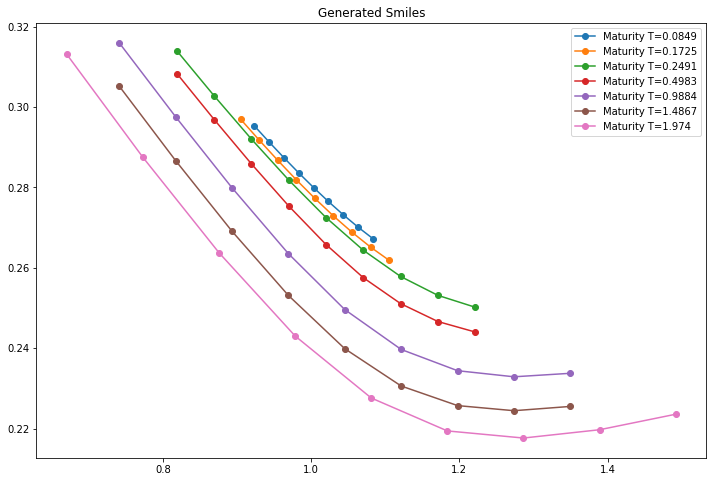

In [55]:
prices, iv= get_iv_Heston_by_params(set_params,strikes,maturities,S0,nbr_strikes)

In [56]:
hours=8
minutes=60*5
days=721
N, initial_price = days*hours*minutes, S0
mu=0.001 #drift
t_0=0
t_final=1
kappa,theta,alpha=set_params['kappa'], set_params['theta'], set_params['alpha']
rho,initial_vol=set_params['rho'], set_params['v0'] 

X,V,B,W,time,noises=sp.Simulate_Heston(N,S0,mu,alpha,kappa,theta,initial_vol,rho,t_final,t_0)

In [58]:
# Of the vol
QV_hat_vol, QV_real_vol, V_daily, W_daily, time_days, p = sp.get_QV_vol_Heston(V,W,days,hours,minutes,alpha)
W_daily, W_daily_ext,q = sp.get_BM_vol(V_daily, W_daily, QV_hat_vol ,QV_real_vol,time_days)

f=row(p,q)
show(f)

#Of the price

QV_hat_price, QV_real_price, X_daily, B_daily, time_days, r = sp.get_QV_price_Heston(X,B,V_daily,days,hours,minutes)
B_daily, B_daily_ext,s= sp.get_BM_price(X_daily, B_daily, QV_hat_price,QV_real_price,time_days)

f1=row(r,s)
show(f1)

In [59]:
noises_x=pc.augment_noises(B_daily_ext,W_daily_ext) #x is the extrapolated one
noises_y=pc.augment_noises(B_daily,W_daily)         #y the real one

Sig_data_frame_x, keys, Sig_x=pc.build_Sig_data_frame_sv(order_Signature,noises_x,days,comp_of_path,time_days)
Sig_data_frame_y, keys, Sig_y=pc.build_Sig_data_frame_sv(order_Signature,noises_y,days,comp_of_path,time_days)


transformed_df_x, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_x,new_tilde,keys,comp_of_path,rho,order_Signature)
transformed_df_y, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_y,new_tilde,keys,comp_of_path,rho,order_Signature)


In [60]:
#os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_joint_calibration\replicate_correct_plots\may')
#np.save('set_calibrated_params.npy',set_calibrated_params_arr)
#np.save('transformed_df_x_B.npy',transformed_df_x[new_keys_B])
#np.save('X_daily.npy',X_daily)
#np.save('iv.npy',iv)

#os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_joint_calibration')

In [61]:
def dimension_coef(order_Signature,d,D):
    return int(((d+1)**(order_Signature)-1)*D/d)
d,D=2,1
dim=dimension_coef(order_Signature+1,d,D)
print(dim)

13


In [62]:
l_initial=np.random.uniform(-0.2,0.2,dim)

Fix a maturity $T$>0

In [63]:
J=0
T=maturities[J]

In [65]:
trunc=int(T*365.25)
trunc

31

In [66]:
Sig_data_frame_x, keys, Sig_x=pc.build_Sig_data_frame_sv(order_Signature,noises_x,trunc,comp_of_path,time_days)

In [67]:
transformed_df_x, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_x,new_tilde,keys,comp_of_path,rho,order_Signature)

In [68]:
transformed_df_x[new_keys_B]

,()~B,(1)~B,(2)~B,(3)~B,"(1,1)~B","(1,2)~B","(1,3)~B","(2,1)~B","(2,2)~B","(2,3)~B","(3,1)~B","(3,2)~B","(3,3)~B"
0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,-0.018168,-0.000013,-0.000528,0.000399,-5.824728e-09,-4.046191e-07,2.647644e-07,7.629717e-08,0.000005,-0.000003,2.430625e-08,1.688452e-06,-1.104846e-06
2,0.002653,0.000031,-0.001383,0.000814,4.090256e-08,-1.708853e-06,1.251391e-06,-3.481290e-07,0.000012,-0.000007,-5.562327e-08,5.687828e-07,4.258528e-07
3,0.009390,0.000054,-0.002036,0.001379,8.194354e-08,-3.833034e-06,3.117791e-06,-4.826102e-07,0.000008,-0.000005,6.797693e-08,-2.049133e-05,1.563797e-05
4,-0.010882,-0.000044,-0.002715,0.000593,-1.585375e-07,-7.345752e-06,9.743829e-07,-2.154196e-07,0.000008,-0.000009,-1.622758e-06,-5.487781e-05,3.306334e-06
5,-0.020579,-0.000105,-0.003256,0.000316,-3.481827e-07,-1.096156e-05,8.534147e-07,3.503497e-08,0.000017,-0.000015,-3.236230e-06,-8.877741e-05,5.535337e-06
6,-0.080326,-0.000561,-0.000935,-0.004310,-2.091336e-06,3.215749e-06,-1.870900e-05,3.974742e-06,-0.000032,0.000002,-1.915982e-05,7.833188e-05,-1.745583e-04
7,-0.108365,-0.000813,0.001017,-0.005879,-3.233019e-06,1.613608e-05,-2.196951e-05,8.741918e-06,-0.000093,-0.000063,-2.985973e-05,2.407856e-04,-2.202735e-04
8,-0.123657,-0.000972,0.002098,-0.006088,-4.061574e-06,2.254978e-05,-1.728166e-05,1.359505e-05,-0.000115,-0.000171,-3.671321e-05,3.469593e-04,-2.177954e-04
9,-0.181137,-0.001650,0.010164,-0.007705,-8.060614e-06,8.936539e-05,-7.823222e-06,4.225635e-05,-0.000685,-0.000489,-6.523608e-05,8.886906e-04,-2.394787e-04


In [69]:
Sig, price_path=transformed_df_x[new_keys_B], X_daily[:trunc]

#### <font color=”darkblue”> Define the first (for $T_{1}$) objective functional for the path, $L_{\text{path}}$ 

In [71]:
def objective_path_lq(l):
    diff = np.dot(Sig,l)+price_path[0] - price_path
    return diff

In [73]:
iv_calibrated=[]

## <font color=”darkblue”> Calibration to option </font>

Compute the vega weights

In [74]:
iv=np.array(np.split(iv,len(maturities)))

In [75]:
def get_vegas(maturities, strikes, initial_price, iv_market, flag_truncation):
    vega=[]
    for i in range(len(maturities)):
        for j in range(len(strikes[i])):
            if flag_truncation==True:
                vega.append(min(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])),1))
            else:
                vega.append(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])))
    vega=np.array(vega)

    vega_by_mat=np.array(np.split(vega,len(maturities)))
    sums_each_strike=np.sum(vega_by_mat, axis=1)
    normalized_vega=np.array([vega_by_mat[j]/sums_each_strike[j] for j in range(len(maturities))])
    flat_normal_weights=normalized_vega.flatten()
    return flat_normal_weights, normalized_vega


flag_truncation=False
flat_normal_weights, norm_vegas=get_vegas(maturities, strikes, S0, iv, flag_truncation)

In [76]:
print('We are interested in the maturity\n T={}'.format(maturities[J]))
print('with strike prices given by\n K={}'.format(strikes[J]))

We are interested in the maturity
 T=0.08487337440109514
with strike prices given by
 K=[0.92311635 0.94313769 0.96315903 0.98318037 1.00320171 1.02322305
 1.04324439 1.06326573 1.08328707]


In [77]:
os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_real_data\Cluster_files')


In [78]:
arr_dfs_by_mat=np.load('arr_dfs_by_mat((7, 1000000, 13)).npy')
arr_dfs_by_mat.shape

(7, 1000000, 13)

In [79]:
sel_maturities=[maturities[J]]
index_sel_maturities=[J]

Vega_W=np.array([np.split(flat_normal_weights,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
Premium1=np.array([np.split(prices,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
arr_dfs_to_optimize=[]
adjusted_scalar_products=[]


In [80]:
def time_varying_model(l,idx_maturity,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price):
    if len([idx_maturity])==1:
        tensor_sigsde_at_mat_aux=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price
        tensor_sigsde_at_mat=tensor_sigsde_at_mat_aux[idx_maturity,:]
    else:
        tensor_prod_last_maturity=np.tensordot(arr_dfs_to_optimize,l,axes=1)
        tensor_prod_last_maturity=np.expand_dims(tensor_prod_last_maturity,1)
        tensor_sigsde_at_mat_aux=np.concatenate((adjusted_scalar_products,tensor_prod_last_maturity),axis=1)
        tensor_sigsde_at_mat=initial_price+np.sum(tensor_sigsde_at_mat_aux,axis=1)
    return tensor_sigsde_at_mat

def get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes):

        '''
        Input: tensor_sigsde_mat (np.array): model at selected maturities

        If len(index_sel_maturities)>1 then dim(tensor_sigsde_at_mat)=(nbr_MC_sim, len(index_sel_maturities))
        If len(index_sel_maturities)=1 then dim(tensor_sigsde_at_mat)=(nbr_MC_sim,)

        index_sel_maturities (list): list of integers corresponding to the selected maturities
        strikes (np.array 2D): array of arrays where each of the sub-array stores the strikes

        Output: Monte Carlo prices of the model for the selected maturities and strikes
        '''
        pay=[]
        if len(index_sel_maturities)==1:

            for K in strikes[index_sel_maturities[0]]:
                matrix=np.maximum(0,tensor_sigsde_at_mat-K)
                pay.append(np.mean(matrix))
            mc_payoff_arr=np.array(pay)
        else:
            for K in strikes[0]:
                matrix_big=[]
                for j in index_sel_maturities:
                    payff=np.maximum(0, tensor_sigsde_at_mat[:,j] - K)
                    matrix_big.append(payff)
                matrix=np.array(matrix_big)
                pay.append(np.mean(matrix,axis=1))
            mc_payoff_arr=np.array(pay).transpose().flatten()
        return mc_payoff_arr


def objective_options(l):
    tensor_sigsde=time_varying_model(l,index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)
    mc_payoff_arr=get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)  
    print('One optimization step completed!')
    return np.sqrt(Vega_W)*(mc_payoff_arr-Premium1)

lambd=0.8
# The following is the so called L_joint
def objective_mix_lq(l):
    conc_=np.concatenate([np.sqrt(1-lambd)*objective_path_lq(l),np.sqrt(lambd)*objective_options(l)],axis=0)
    return conc_
    
    
n=order_Signature
l_initial=np.random.uniform(-0.2,0.2,int(((d+1)**(n+1)-1)*D/d))

In [81]:
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res1 = least_squares(objective_options, l_initial,loss='linear')

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

In [82]:
tensor_sigsde_at_mat=time_varying_model(res1['x'],index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes)

def implied_vol_minimize( price, S0, K, T, r, payoff="call", disp=True ):
    """ Returns Implied volatility by minimization"""
    
    n = 2     # must be even
    def obj_fun(vol):
        return ( BlackScholes(True, S0, K, T, r, 0., vol) - price)**n
        
    res = minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return -1

def get_iv_from_calib_onemat(calibrated_prices,strikes,maturity,idx_mat,S0):
    iv_calib_mc=[]
    
    for k in range(len(strikes[idx_mat])):
         iv_calib_mc.append(implied_vol_minimize(calibrated_prices[k], S0, strikes[idx_mat][k], maturity, 0, payoff="call", disp=True))
    return np.array(iv_calib_mc)
    

def get_iv_from_calib(calibrated_prices,strikes,maturities,S0):
    sig_prices_mc_arr=[]
    iv_calib_mc=[]
    
    sig_prices_mc_arr=np.array(np.split(calibrated_prices,len(maturities)))
        
    for j in range(len(maturities)):
        for k in range(len(strikes[j])):
                iv_calib_mc.append(implied_vol_minimize(sig_prices_mc_arr[j,k], S0, strikes[j][k], maturities[j], 0, payoff="call", disp=True))

    iv_calib_arr_mc=np.array([np.array(iv_calib_mc[k*len(strikes[0]):(k+1)*len(strikes[0])]) for k in range(len(maturities))])
    return iv_calib_arr_mc, sig_prices_mc_arr

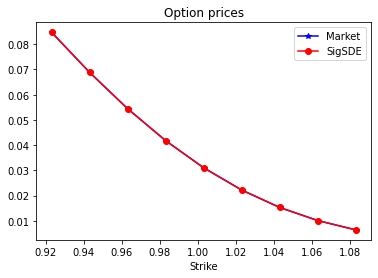

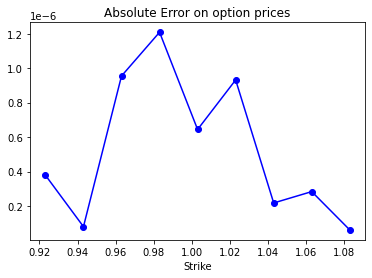

In [83]:
tensor_sigsde_at_mat=time_varying_model(res1['x'],index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes)

plt.plot(strikes[J],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[J],calibrated_prices,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[J],np.abs(Premium1-calibrated_prices),marker='o',color='b')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()


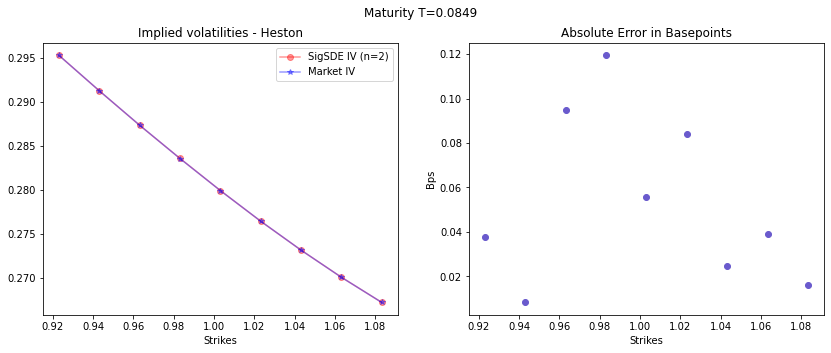

In [84]:
iv_mc=[]
iv_market=np.array(np.split(iv,len(maturities)))
%matplotlib inline

iv_calib_arr_mc_slice=get_iv_from_calib_onemat(calibrated_prices,strikes,maturities[J],J,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[J],4)))
ax1.plot(strikes[J], iv_calib_arr_mc_slice,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[J], iv[J],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[J],np.abs( iv_calib_arr_mc_slice-iv[J])*10000,color='slateblue') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_MC_TV2(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=500)
plt.show()


In [85]:
res1['x']

array([ 0.28049231, -0.17613823, -0.07761182, -0.12238047, -0.04723014,
        0.09070794, -0.38601045, -0.46650069,  0.00853063,  0.29252449,
        0.14676935, -0.06960279,  0.45206196])

In [86]:
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res2= least_squares(objective_path_lq, l_initial,loss='linear')
    

  0%|          | 0/1 [00:00<?, ?it/s]

In [87]:
Sig_data_frame_xx, keysx, Sig_xx=pc.build_Sig_data_frame_sv(order_Signature,noises_x,days,comp_of_path,time_days)
transformed_df_xx, new_keys_Bx=pc.transform_data_frame_sv(Sig_data_frame_xx,new_tilde,keys,comp_of_path,rho,order_Signature)

ww=trunc
q = figure(width=500, height=350,title='Path calibration')
q1 = q.line(time_days[:trunc+ww],(np.dot(transformed_df_xx[new_keys_B],res2['x'])+S0)[:trunc+ww], legend_label='Sig-SDE', line_color='tomato')
q2 = q.line(time_days[:trunc+ww],X_daily[:trunc+ww], legend_label='Heston', line_color='royalblue')
q3= q.line([time_days[trunc],time_days[trunc]], [min((np.dot(transformed_df_xx[new_keys_B],res2['x'])+S0)[:trunc+ww]),max((np.dot(transformed_df_xx[new_keys_B],res2['x'])+S0)[:trunc+ww])], line_width=1,line_color='orange',line_dash='dashed')
show(q)
print('MSE:',np.sum(((np.dot(transformed_df_xx[new_keys_B],res2['x'])+S0)[:trunc+ww]-X_daily[:trunc+ww])**2))

q = figure(width=500, height=350,title='Path calibration with options parameters')
q1 = q.line(time_days[:trunc+ww],(np.dot(transformed_df_xx[new_keys_B],res1['x'])+S0)[:trunc+ww], legend_label='Sig-SDE', line_color='tomato')
q2 = q.line(time_days[:trunc+ww],X_daily[:trunc+ww], legend_label='Heston', line_color='royalblue')
q3= q.line([time_days[trunc],time_days[trunc]], [min((np.dot(transformed_df_xx[new_keys_B],res1['x'])+S0)[:trunc+ww]),max((np.dot(transformed_df_xx[new_keys_B],res1['x'])+S0)[:trunc+ww])], line_width=1,line_color='orange',line_dash='dashed')
show(q)
print('MSE:',np.sum(((np.dot(transformed_df_xx[new_keys_B],res1['x'])+S0)[:trunc+ww]-X_daily[:trunc+ww])**2))

q = figure(width=500, height=350,title='Path calibration with options parameters with a minus in front')
q1 = q.line(time_days[:trunc+ww],(-np.dot(transformed_df_xx[new_keys_B],res1['x'])+S0)[:trunc+ww], legend_label='Sig-SDE', line_color='tomato')
q2 = q.line(time_days[:trunc+ww],X_daily[:trunc+ww], legend_label='Heston', line_color='royalblue')
q3= q.line([time_days[trunc],time_days[trunc]], [min((-np.dot(transformed_df_xx[new_keys_B],res1['x'])+S0)[:trunc+ww]),max((-np.dot(transformed_df_xx[new_keys_B],res1['x'])+S0)[:trunc+ww])], line_width=1,line_color='orange',line_dash='dashed')
show(q)
print('MSE:',np.sum(((-np.dot(transformed_df_xx[new_keys_B],res1['x'])+S0)[:trunc+ww]-X_daily[:trunc+ww])**2))

MSE: 0.0002763881333376328


MSE: 0.0009246529687306708


MSE: 0.13090060381874957


In [88]:
res2['x']

array([ 0.28130802,  0.40984584,  0.03858925,  0.16115708,  0.29265848,
        0.21258639, -0.16745368,  1.01914635, -1.1983864 , -0.48933846,
       -0.54996917,  0.03088649, -0.64382214])

In [89]:
res1['x']

array([ 0.28049231, -0.17613823, -0.07761182, -0.12238047, -0.04723014,
        0.09070794, -0.38601045, -0.46650069,  0.00853063,  0.29252449,
        0.14676935, -0.06960279,  0.45206196])

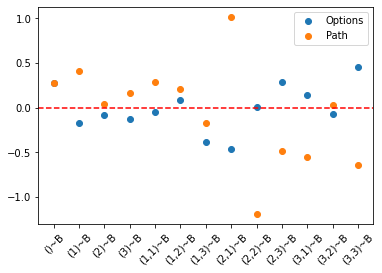

In [90]:
plt.scatter(new_keys_B,res1['x'],label='Options')
plt.scatter(new_keys_B,res2['x'],label='Path')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [91]:
l_aux=res1['x']+np.random.normal(0,0.001,dim)
#l_initial=np.random.uniform(-0.4,0.4,dim)

In [92]:
for t in tqdm(range(1)):
    sol_mix= least_squares(objective_mix_lq, l_aux,loss='soft_l1')

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

In [93]:
for t in tqdm(range(1)):
    sol_mix2= least_squares(objective_mix_lq, l_initial,loss='linear')

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

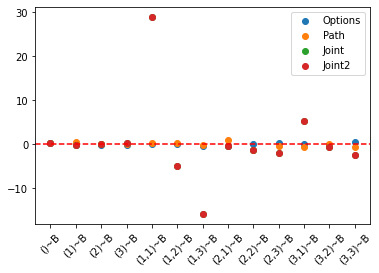

In [94]:
plt.scatter(new_keys_B,res1['x'],label='Options')
plt.scatter(new_keys_B,res2['x'],label='Path')
plt.scatter(new_keys_B,sol_mix['x'],label='Joint')
plt.scatter(new_keys_B,sol_mix2['x'],label='Joint2')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [95]:
print('Loss of the mixed problem with the joint param:',np.sum((objective_mix_lq(sol_mix['x']))**2))
print('Loss of the mixed problem with the joint param2:',np.sum((objective_mix_lq(sol_mix2['x']))**2))
print('Loss of the mixed problem with path param:',np.sum((objective_mix_lq(res1['x']))**2))
print('Loss of the mixed problem with option param:',np.sum((objective_mix_lq(res2['x']))**2))

One optimization step completed!
Loss of the mixed problem with the joint param: 3.168291274814357e-08
One optimization step completed!
Loss of the mixed problem with the joint param2: 3.168291695177142e-08
One optimization step completed!
Loss of the mixed problem with path param: 7.139292257632502e-05
One optimization step completed!
Loss of the mixed problem with option param: 3.018199971503843e-07


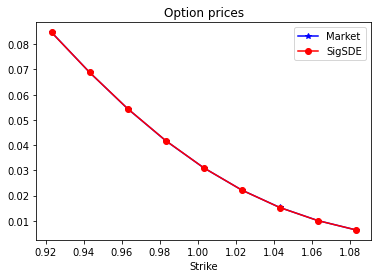

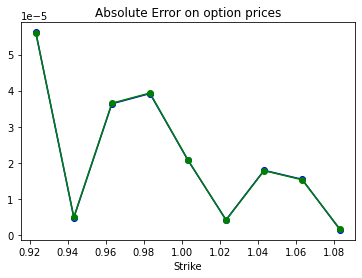

In [96]:
tensor_sigsde_at_mat_MIX=time_varying_model(sol_mix['x'],index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices_MIX=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat_MIX,index_sel_maturities,strikes)

tensor_sigsde_at_mat_MIX1=time_varying_model(sol_mix2['x'],index_sel_maturities[0],arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices_MIX1=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat_MIX1,index_sel_maturities,strikes)
j=J
plt.plot(strikes[j],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[j],calibrated_prices_MIX,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[j],np.abs(Premium1-calibrated_prices_MIX),marker='o',color='b')
plt.plot(strikes[j],np.abs(Premium1-calibrated_prices_MIX1),marker='o',color='g')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()

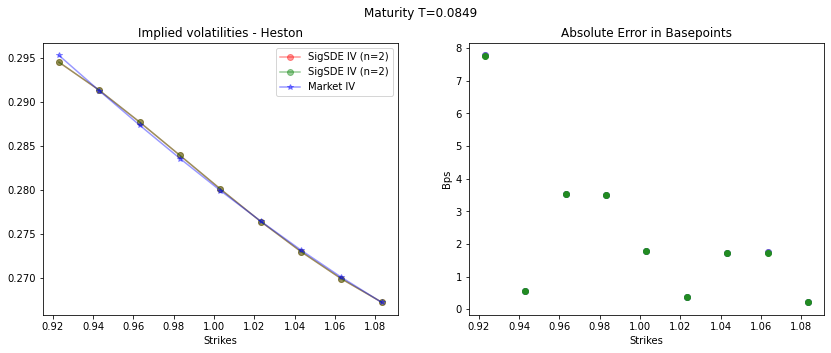

In [97]:
iv_mc_MIX=[]
#iv_market=np.array(np.split(iv,len(maturities)))
%matplotlib inline
j=J
iv_calib_arr_mc_slice_MIX=get_iv_from_calib_onemat(calibrated_prices_MIX,strikes,maturities[j],j,S0)
iv_calib_arr_mc_slice_MIX1=get_iv_from_calib_onemat(calibrated_prices_MIX1,strikes,maturities[j],j,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
ax1.plot(strikes[j], iv_calib_arr_mc_slice_MIX,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[j], iv_calib_arr_mc_slice_MIX1,marker='o',color='g',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[j], iv[j],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[j],np.abs( iv_calib_arr_mc_slice_MIX-iv[j])*10000,color='slateblue') 
ax2.scatter(strikes[j],np.abs( iv_calib_arr_mc_slice_MIX1-iv[j])*10000,color='forestgreen') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_HE_joint(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=250)
plt.show()

In [98]:
noises_x=pc.augment_noises(B_daily_ext,W_daily_ext) #x is the extrapolated one

Sig_data_frame_x, keys, Sig_x=pc.build_Sig_data_frame_sv(order_Signature,noises_x,days,comp_of_path,time_days)

transformed_df_x, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_x,new_tilde,keys,comp_of_path,rho,order_Signature)


In [99]:
year=365.25
ww=trunc
grid_in_and_out_sample=np.array(range(trunc+ww))/year
grid_in_sample=np.array(range(trunc+1))/year
path_approximated_1=np.dot(transformed_df_x[new_keys_B],sol_mix['x'])+S0
path_approximated_2=np.dot(transformed_df_x[new_keys_B],sol_mix2['x'])+S0

q = figure(width=500, height=400,title='Joint calibration with weight {}'.format(lambd) + ' on the options')
q1 = q.line(grid_in_and_out_sample,path_approximated_1[:trunc+ww], legend_label='Sig-SDE', line_color='tomato')
q2 = q.circle(grid_in_and_out_sample,path_approximated_1[:trunc+ww], fill_color='tomato')

q3 = q.line(grid_in_and_out_sample,path_approximated_2[:trunc+ww], legend_label='Sig-SDE', line_color='tomato')
q4 = q.circle(grid_in_and_out_sample,path_approximated_2[:trunc+ww], fill_color='forestgreen')

q5 = q.line(grid_in_and_out_sample,X_daily[:trunc+ww], legend_label='Heston', line_color='royalblue')
q6= q.line([grid_in_sample[-1],grid_in_sample[-1]], [min(path_approximated_2[:trunc+ww]),max(path_approximated_2[:trunc+ww])], line_width=1,line_color='orange',line_dash='dashed')
q.legend.location = "top_left"
#show(q)


b = figure(width=500, height=400,title='IV at maturity T={}'.format(round(T,4)))

b1 = b.circle(strikes[j],iv_calib_arr_mc_slice_MIX,legend_label='Sig IV',fill_alpha=0.2,size=7,color="red")
b2 = b.circle(strikes[j],iv_calib_arr_mc_slice_MIX1,legend_label='Sig IV',fill_alpha=0.2,size=7,color="forestgreen")
b3 = b.star(strikes[j],iv[j],legend_label='Heston IV',fill_alpha=0.2,size=7,color="navy")
b.xaxis.axis_label = 'Strike Price'
b.yaxis.axis_label = 'IV'
b.legend.location = "top_right"
show(row(q,b))

In [100]:
ww=trunc
q = figure(width=500, height=400,title='Joint calibration with weight {}'.format(lambd) + ' on the options')

q3 = q.line(grid_in_and_out_sample,path_approximated_2[:trunc+ww], legend_label='SigSDE', line_color='tomato')
q4 = q.circle(grid_in_and_out_sample,path_approximated_2[:trunc+ww], fill_color='tomato')

q5 = q.line(grid_in_and_out_sample,X_daily[:trunc+ww], legend_label='Heston', line_color='navy')
q6= q.line([grid_in_sample[-1],grid_in_sample[-1]], [min(path_approximated_2[:trunc+ww]),max(path_approximated_2[:trunc+ww])], line_width=1,line_color='tomato',line_dash='dashed')
q.legend.location = "bottom_left"
#show(q)


b = figure(width=500, height=400,title='IV at maturity T={}'.format(round(T,4)))

b2 = b.circle(strikes[j],iv_calib_arr_mc_slice_MIX1,legend_label=f'SigSDE IV (n={n})',fill_alpha=0.2,size=7,color="tomato")
b3 = b.line(strikes[j],iv_calib_arr_mc_slice_MIX1,legend_label=f'SigSDE IV (n={n})',color="tomato")
b4 = b.star(strikes[j],iv[j],legend_label='Heston IV',fill_alpha=0.2,size=7,color="navy")
b.xaxis.axis_label = 'Strike Price'
b.yaxis.axis_label = 'IV'
b.legend.location = "bottom_left"
show(row(q,b))

In [101]:
b = figure(width=500, height=400,title='IV Absolute Error at maturity T={}'.format(round(T,4)))
b2 = b.circle(strikes[j],np.abs( iv_calib_arr_mc_slice_MIX1-iv[j])*10000,fill_alpha=0.4,size=7,legend_label='Error',color="tomato")
b.xaxis.axis_label = 'Strike Price'
b.yaxis.axis_label = 'Bps'
b.legend.location = "top_left"
show(b)

In [102]:
iv_calibrated.append(iv_calib_arr_mc_slice_MIX1)

# Second maturity

In [103]:
set_calibrated_params=[]
set_calibrated_params.append(sol_mix2['x'])

In [104]:
noises_x=pc.augment_noises(B_daily_ext,W_daily_ext) #x is the extrapolated one
Sig_data_frame_x, keys, Sig_x=pc.build_Sig_data_frame_sv(order_Signature,noises_x,days,comp_of_path,time_days)
transformed_df_x, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_x,new_tilde,keys,comp_of_path,rho,order_Signature)

In [105]:
J=1
T=maturities[J]
T_1=maturities[J-1]
trunc_1=int(T_1*365.25)
trunc=int(T*365.25)
Sig_data_frame_x, keys, Sig_x=pc.build_Sig_data_frame_sv(order_Signature,noises_x,trunc,comp_of_path,time_days)
transformed_df_x, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_x,new_tilde,keys,comp_of_path,rho,order_Signature)
transformed_df_x[new_keys_B]

,()~B,(1)~B,(2)~B,(3)~B,"(1,1)~B","(1,2)~B","(1,3)~B","(2,1)~B","(2,2)~B","(2,3)~B","(3,1)~B","(3,2)~B","(3,3)~B"
0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,-0.018168,-0.000013,-0.000528,0.000399,-5.824728e-09,-4.046191e-07,2.647644e-07,7.629717e-08,0.000005,-0.000003,2.430625e-08,1.688452e-06,-1.104846e-06
2,0.002653,0.000031,-0.001383,0.000814,4.090256e-08,-1.708853e-06,1.251391e-06,-3.481290e-07,0.000012,-0.000007,-5.562327e-08,5.687828e-07,4.258528e-07
3,0.009390,0.000054,-0.002036,0.001379,8.194354e-08,-3.833034e-06,3.117791e-06,-4.826102e-07,0.000008,-0.000005,6.797693e-08,-2.049133e-05,1.563797e-05
4,-0.010882,-0.000044,-0.002715,0.000593,-1.585375e-07,-7.345752e-06,9.743829e-07,-2.154196e-07,0.000008,-0.000009,-1.622758e-06,-5.487781e-05,3.306334e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.093172,0.008339,-0.035881,0.004761,2.220021e-04,-9.237716e-04,8.986632e-04,-6.111058e-04,0.000557,0.002852,-3.238160e-04,2.022911e-04,-1.624602e-03
59,0.105285,0.009322,-0.035373,0.002839,2.618728e-04,-8.730991e-04,8.034303e-04,-6.205097e-04,0.000548,0.002859,-3.846343e-04,1.331920e-04,-1.475565e-03
60,0.101955,0.009047,-0.036411,0.004014,2.505340e-04,-9.609115e-04,8.827098e-04,-6.183988e-04,0.000458,0.002924,-3.669138e-04,3.630605e-04,-1.665520e-03
61,0.085405,0.007658,-0.038655,0.009032,1.922667e-04,-1.157371e-03,1.209473e-03,-6.101970e-04,0.000320,0.003155,-2.726058e-04,7.979823e-04,-2.422647e-03


In [106]:
adjustement_1=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_1]

In [107]:
first_param=np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])

In [108]:
Sig, price_path=adjustement_1, X_daily[:trunc]

def objective_path_lq(l):
    diff = np.dot(Sig,l)+first_param+price_path[0] - price_path
    return diff

In [109]:
sel_maturities=[maturities[J]]
index_sel_maturities=[J]

Vega_W=np.array([np.split(flat_normal_weights,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
Premium1=np.array([np.split(prices,len(maturities))[idx] for idx in index_sel_maturities]).flatten()

In [110]:
j=J
arr_dfs_by_mat_swap=np.swapaxes(arr_dfs_by_mat,0,1)

In [111]:
adjusted_arr_dfs=[arr_dfs_by_mat_swap[:,j,:]-arr_dfs_by_mat_swap[:,idx,:] for idx in range(0,j-1)]
adjusted_arr_dfs.insert(0,arr_dfs_by_mat_swap[:,j,:])
adjusted_arr_dfs=np.array(adjusted_arr_dfs)
arr_dfs_to_optimize=arr_dfs_by_mat_swap[:,j,:]-arr_dfs_by_mat_swap[:,j-1,:]
adjusted_scalar_products=np.array([np.tensordot(adjusted_arr_dfs[k],set_calibrated_params[k],axes=1) for k in range(j)])
adjusted_scalar_products=adjusted_scalar_products.transpose()

In [112]:
def time_varying_model2(l,idx_maturity,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,initial_price):
    if (idx_maturity[0]==0): 
        tensor_sigsde_at_mat_aux=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price
        tensor_sigsde_at_mat=tensor_sigsde_at_mat_aux[:,idx_maturity]
    else:
        tensor_prod_last_maturity=np.tensordot(arr_dfs_to_optimize,l,axes=1)
        tensor_prod_last_maturity=np.expand_dims(tensor_prod_last_maturity,1)
        tensor_sigsde_at_mat_aux=np.concatenate((adjusted_scalar_products,tensor_prod_last_maturity),axis=1)
        tensor_sigsde_at_mat=initial_price+np.sum(tensor_sigsde_at_mat_aux,axis=1)
    return tensor_sigsde_at_mat

In [113]:
def objective_options(l):
    tensor_sigsde=time_varying_model2(l,index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)
    mc_payoff_arr=get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)  
    print('One optimization step completed!')
    return np.sqrt(Vega_W)*(mc_payoff_arr-Premium1)

lambd=0.88
def objective_mix_lq(l):
    conc_=np.concatenate([np.sqrt(1-lambd)*objective_path_lq(l),np.sqrt(lambd)*objective_options(l)],axis=0)
    return conc_
    

In [114]:
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res1 = least_squares(objective_options, l_initial,loss='linear')

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

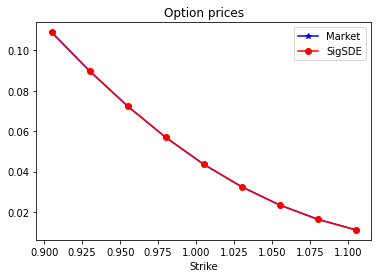

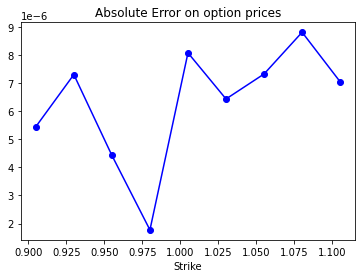

In [115]:
tensor_sigsde_at_mat=time_varying_model2(res1['x'],index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes)

plt.plot(strikes[J],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[J],calibrated_prices,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[J],np.abs(Premium1-calibrated_prices),marker='o',color='b')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()


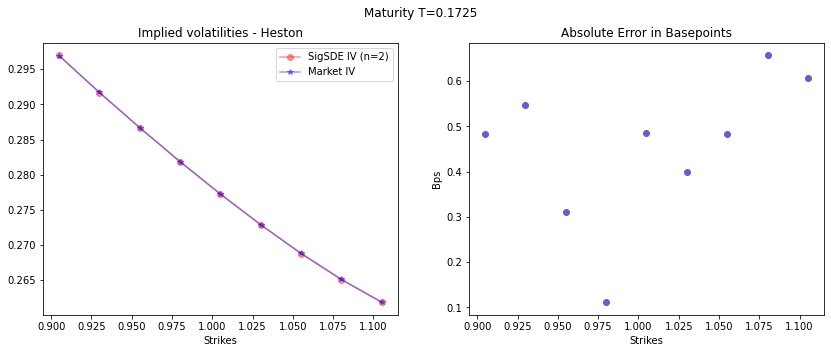

In [116]:
iv_calib_arr_mc_slice=get_iv_from_calib_onemat(calibrated_prices,strikes,maturities[J],J,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[J],4)))
ax1.plot(strikes[J], iv_calib_arr_mc_slice,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[J], iv[J],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[J],np.abs( iv_calib_arr_mc_slice-iv[J])*10000,color='slateblue') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_MC_TV2(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=500)
plt.show()

In [117]:
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res2= least_squares(objective_path_lq, l_initial,loss='linear')
    

  0%|          | 0/1 [00:00<?, ?it/s]

In [118]:
l_aux=res1['x']+np.random.normal(0,0.001,dim)

for t in tqdm(range(1)):
    sol_mix2= least_squares(objective_mix_lq, l_aux,loss='linear')

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

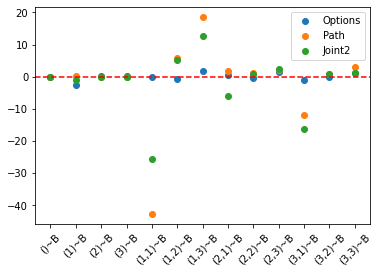

One optimization step completed!
Loss of the mixed problem with the joint param2: 1.139584754243518e-07
One optimization step completed!
Loss of the mixed problem with path param: 0.000895211166144472
One optimization step completed!
Loss of the mixed problem with option param: 8.746850026172375e-06


In [119]:
plt.scatter(new_keys_B,res1['x'],label='Options')
plt.scatter(new_keys_B,res2['x'],label='Path')
plt.scatter(new_keys_B,sol_mix2['x'],label='Joint2')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

print('Loss of the mixed problem with the joint param2:',np.sum((objective_mix_lq(sol_mix2['x']))**2))
print('Loss of the mixed problem with path param:',np.sum((objective_mix_lq(res1['x']))**2))
print('Loss of the mixed problem with option param:',np.sum((objective_mix_lq(res2['x']))**2))

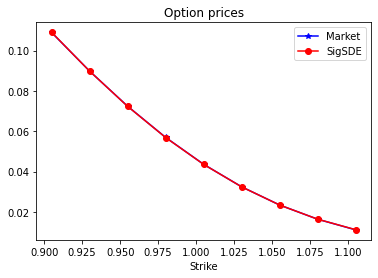

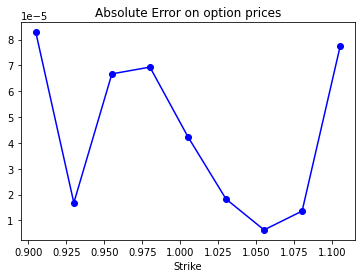

In [120]:
tensor_sigsde_at_mat_MIX2=time_varying_model2(sol_mix2['x'],index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices_MIX2=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat_MIX2,index_sel_maturities,strikes)
j=J
plt.plot(strikes[j],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[j],calibrated_prices_MIX2,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[j],np.abs(Premium1-calibrated_prices_MIX2),marker='o',color='b')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()

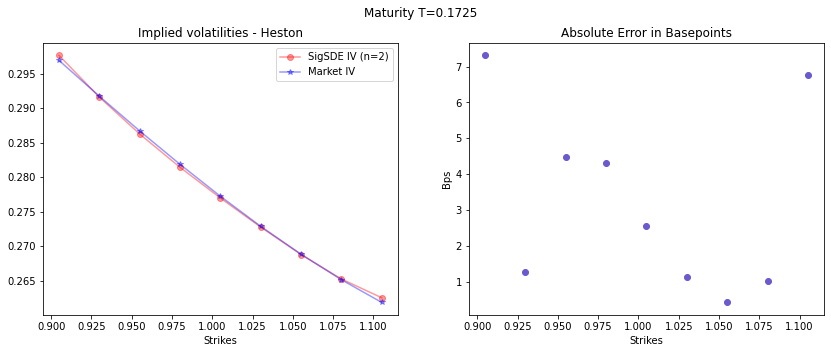

In [121]:
j=J
iv_calib_arr_mc_slice_MIX2=get_iv_from_calib_onemat(calibrated_prices_MIX2,strikes,maturities[j],j,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
ax1.plot(strikes[j], iv_calib_arr_mc_slice_MIX2,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[j], iv[j],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[j],np.abs( iv_calib_arr_mc_slice_MIX2-iv[j])*10000,color='slateblue') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_HE_joint(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=250)
plt.show()

In [122]:
second_part=(np.dot(Sig,sol_mix2['x'])+first_param+price_path[0])[trunc_1:trunc]

In [123]:
first_part=(np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])+price_path[0])[:trunc_1]

In [124]:
aux=np.concatenate([first_part,second_part],axis=0)

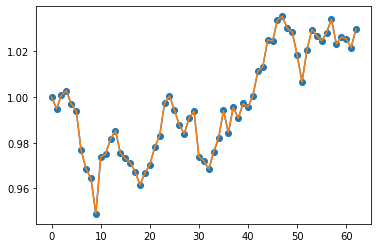

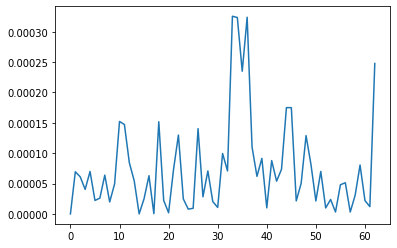

In [125]:
plt.plot(aux,marker='o')
plt.plot(X_daily[:trunc])
plt.show()

plt.plot(np.abs((aux-X_daily[:trunc])))
plt.show()

In [126]:
iv_calibrated.append(iv_calib_arr_mc_slice_MIX2)

# Third maturity

In [127]:
set_calibrated_params.append(sol_mix2['x'])

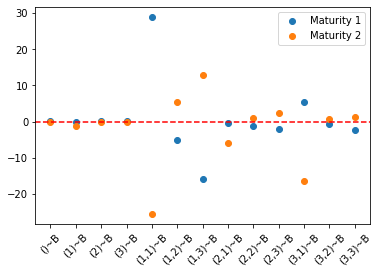

In [128]:
plt.scatter(new_keys_B,set_calibrated_params[0],label='Maturity 1')
plt.scatter(new_keys_B,set_calibrated_params[1],label='Maturity 2')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [129]:
J=2
T=maturities[J]
T_1=maturities[J-1]
T_2=maturities[J-2]

trunc_2=int(T_2*365.25)
trunc_1=int(T_1*365.25)
trunc=int(T*365.25)

In [130]:
noises_x=pc.augment_noises(B_daily_ext,W_daily_ext) #x is the extrapolated one
Sig_data_frame_x, keys, Sig_x=pc.build_Sig_data_frame_sv(order_Signature,noises_x,trunc,comp_of_path,time_days)
transformed_df_x, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_x,new_tilde,keys,comp_of_path,rho,order_Signature)
transformed_df_x[new_keys_B]



adjustment_2=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_2]

adjustment_1=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_1]

first_param=np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])

price_path=X_daily[:trunc]


In [131]:
print(adjustment_1.shape)
print(adjustment_2.shape)
print(first_param.shape)
print(price_path.shape)

(91, 13)
(91, 13)
(91,)
(91,)


In [132]:
def objective_path_lq(l):
    diff = np.dot(adjustment_1,l)+np.dot(adjustment_2,set_calibrated_params[1])+first_param+price_path[0] - price_path
    return diff

sel_maturities=[maturities[J]]
index_sel_maturities=[J]

Vega_W=np.array([np.split(flat_normal_weights,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
Premium1=np.array([np.split(prices,len(maturities))[idx] for idx in index_sel_maturities]).flatten()

j=J
arr_dfs_by_mat_swap=np.swapaxes(arr_dfs_by_mat,0,1)

adjusted_arr_dfs=[arr_dfs_by_mat_swap[:,j,:]-arr_dfs_by_mat_swap[:,idx,:] for idx in range(0,j-1)]
adjusted_arr_dfs.insert(0,arr_dfs_by_mat_swap[:,j,:])
adjusted_arr_dfs=np.array(adjusted_arr_dfs)
arr_dfs_to_optimize=arr_dfs_by_mat_swap[:,j,:]-arr_dfs_by_mat_swap[:,j-1,:]
adjusted_scalar_products=np.array([np.tensordot(adjusted_arr_dfs[k],set_calibrated_params[k],axes=1) for k in range(j)])
adjusted_scalar_products=adjusted_scalar_products.transpose()

In [158]:
def objective_options(l):
    tensor_sigsde=time_varying_model2(l,index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)
    mc_payoff_arr=get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)  
    print('One optimization step completed!')
    return np.sqrt(Vega_W)*(mc_payoff_arr-Premium1)

lambd=0.99995
def objective_mix_lq(l):
    conc_=np.concatenate([np.sqrt(1-lambd)*objective_path_lq(l),np.sqrt(lambd)*objective_options(l)],axis=0)
    return conc_
    

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!


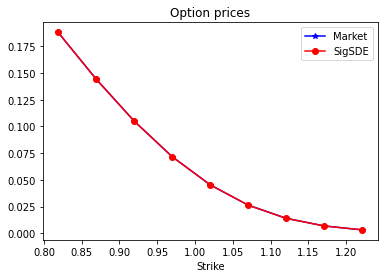

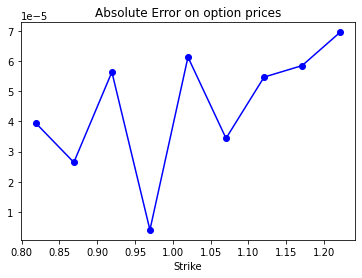

In [147]:
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res1 = least_squares(objective_options, l_initial,loss='linear')

tensor_sigsde_at_mat=time_varying_model2(res1['x'],index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes)

plt.plot(strikes[J],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[J],calibrated_prices,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[J],np.abs(Premium1-calibrated_prices),marker='o',color='b')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()



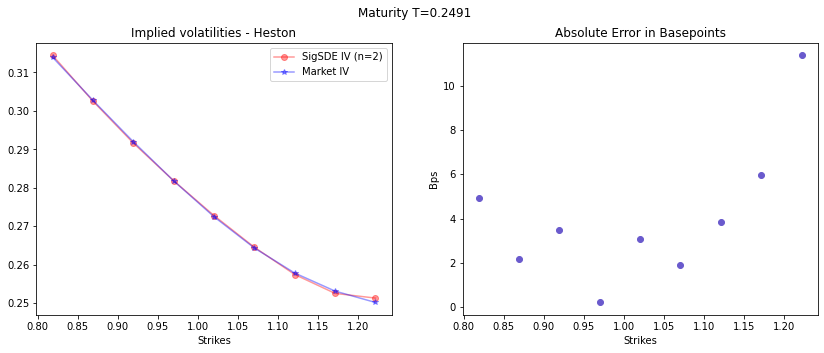

In [148]:
iv_calib_arr_mc_slice=get_iv_from_calib_onemat(calibrated_prices,strikes,maturities[J],J,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[J],4)))
ax1.plot(strikes[J], iv_calib_arr_mc_slice,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[J], iv[J],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[J],np.abs( iv_calib_arr_mc_slice-iv[J])*10000,color='slateblue') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_MC_TV2(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=500)
plt.show()

In [159]:
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res2= least_squares(objective_path_lq, l_initial,loss='linear')
    

l_aux=res1['x']+np.random.normal(0,0.001,dim)

for t in tqdm(range(1)):
    sol_mix2= least_squares(objective_mix_lq, l_aux,loss='linear')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

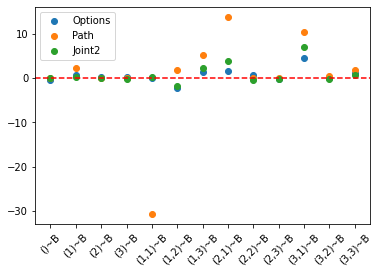

One optimization step completed!
Loss of the mixed problem with the joint param2: 1.4382372726734612e-08
One optimization step completed!
Loss of the mixed problem with path param: 9.344509836384925e-06
One optimization step completed!
Loss of the mixed problem with option param: 0.0007637283850003264


In [160]:
plt.scatter(new_keys_B,res1['x'],label='Options')
plt.scatter(new_keys_B,res2['x'],label='Path')
plt.scatter(new_keys_B,sol_mix2['x'],label='Joint2')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

print('Loss of the mixed problem with the joint param2:',np.sum((objective_mix_lq(sol_mix2['x']))**2))
print('Loss of the mixed problem with path param:',np.sum((objective_mix_lq(res1['x']))**2))
print('Loss of the mixed problem with option param:',np.sum((objective_mix_lq(res2['x']))**2))

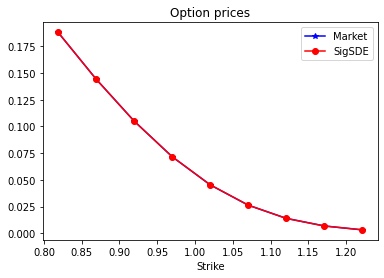

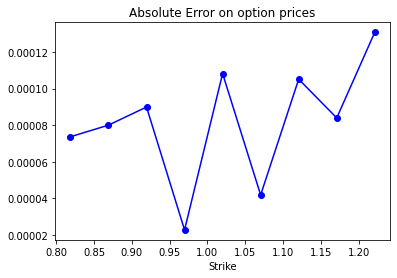

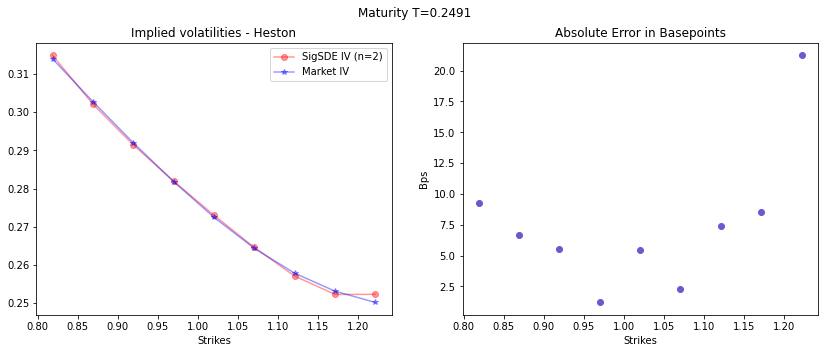

In [161]:
tensor_sigsde_at_mat_MIX2=time_varying_model2(sol_mix2['x'],index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices_MIX2=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat_MIX2,index_sel_maturities,strikes)
j=J
plt.plot(strikes[j],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[j],calibrated_prices_MIX2,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[j],np.abs(Premium1-calibrated_prices_MIX2),marker='o',color='b')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()

j=J
iv_calib_arr_mc_slice_MIX2=get_iv_from_calib_onemat(calibrated_prices_MIX2,strikes,maturities[j],j,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
ax1.plot(strikes[j], iv_calib_arr_mc_slice_MIX2,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[j], iv[j],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[j],np.abs( iv_calib_arr_mc_slice_MIX2-iv[j])*10000,color='slateblue') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_HE_joint(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=250)
plt.show()

In [162]:
path_approx=np.dot(adjustment_1,sol_mix2['x'])+np.dot(adjustment_2,set_calibrated_params[1])+first_param+price_path[0]

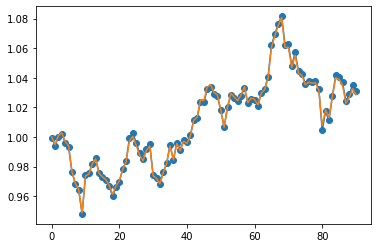

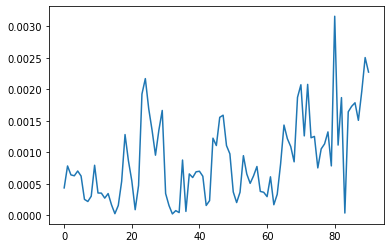

In [163]:

plt.plot(path_approx,marker='o')
plt.plot(X_daily[:trunc])
plt.show()

plt.plot(np.abs((path_approx-X_daily[:trunc])))
plt.show()

In [164]:
iv_calibrated.append(iv_calib_arr_mc_slice_MIX2)

store parameters

In [165]:
set_calibrated_params.append(sol_mix2['x'])

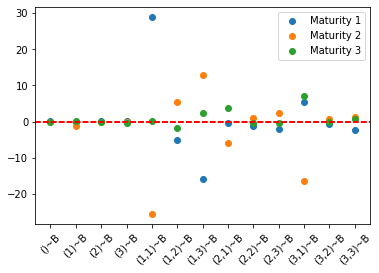

In [166]:
for t in range(j+1):
    plt.scatter(new_keys_B,set_calibrated_params[t],label='Maturity '+str(t+1))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xticks(rotation=45)
plt.legend()
plt.show()

# Fourth maturity

In [167]:
J=3
T=maturities[J]
T_1=maturities[J-1]
T_2=maturities[J-2]
T_3=maturities[J-3]

trunc_3=int(T_3*365.25)
trunc_2=int(T_2*365.25)
trunc_1=int(T_1*365.25)
trunc=int(T*365.25)

print(trunc)
print(trunc_1)
print(trunc_2)
print(trunc_3)

182
91
63
31


In [168]:
noises_x=pc.augment_noises(B_daily_ext,W_daily_ext) #x is the extrapolated one
Sig_data_frame_x, keys, Sig_x=pc.build_Sig_data_frame_sv(order_Signature,noises_x,trunc,comp_of_path,time_days)
transformed_df_x, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_x,new_tilde,keys,comp_of_path,rho,order_Signature)

In [169]:
adjustment_3=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_3]

adjustment_2=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_2]

adjustment_1=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_1]

first_param=np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])

price_path=X_daily[:trunc]


In [170]:
trunc_3

31

In [171]:
print(adjustment_1.shape)
print(adjustment_2.shape)
print(adjustment_3.shape)
print(first_param.shape)
print(price_path.shape)

(182, 13)
(182, 13)
(182, 13)
(182,)
(182,)


In [172]:
def objective_path_lq(l):
    np_dot_3=np.dot(adjustment_3,set_calibrated_params[2])
    np_dot_2=np.dot(adjustment_2,set_calibrated_params[1])
    
    diff = np.dot(adjustment_1,l)+np_dot_3+np_dot_2+first_param+price_path[0] - price_path
    return diff

sel_maturities=[maturities[J]]
index_sel_maturities=[J]

Vega_W=np.array([np.split(flat_normal_weights,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
Premium1=np.array([np.split(prices,len(maturities))[idx] for idx in index_sel_maturities]).flatten()

j=J
arr_dfs_by_mat_swap=np.swapaxes(arr_dfs_by_mat,0,1)

adjusted_arr_dfs=[arr_dfs_by_mat_swap[:,j,:]-arr_dfs_by_mat_swap[:,idx,:] for idx in range(0,j-1)]
adjusted_arr_dfs.insert(0,arr_dfs_by_mat_swap[:,j,:])
adjusted_arr_dfs=np.array(adjusted_arr_dfs)
arr_dfs_to_optimize=arr_dfs_by_mat_swap[:,j,:]-arr_dfs_by_mat_swap[:,j-1,:]
adjusted_scalar_products=np.array([np.tensordot(adjusted_arr_dfs[k],set_calibrated_params[k],axes=1) for k in range(j)])
adjusted_scalar_products=adjusted_scalar_products.transpose()

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

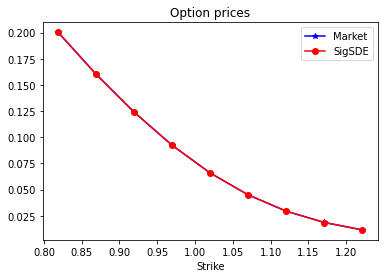

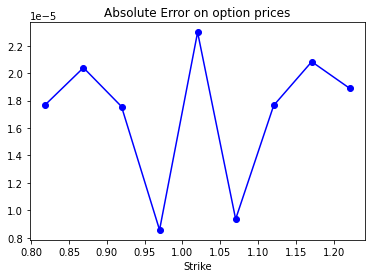

In [173]:
def objective_options(l):
    tensor_sigsde=time_varying_model2(l,index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)
    mc_payoff_arr=get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)  
    print('One optimization step completed!')
    return np.sqrt(Vega_W)*(mc_payoff_arr-Premium1)


for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res1 = least_squares(objective_options, l_initial,loss='linear')

tensor_sigsde_at_mat=time_varying_model2(res1['x'],index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes)

plt.plot(strikes[J],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[J],calibrated_prices,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[J],np.abs(Premium1-calibrated_prices),marker='o',color='b')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()



In [186]:
lambd=0.992
def objective_mix_lq(l):
    conc_=np.concatenate([np.sqrt(1-lambd)*objective_path_lq(l),np.sqrt(lambd)*objective_options(l)],axis=0)
    return conc_
    

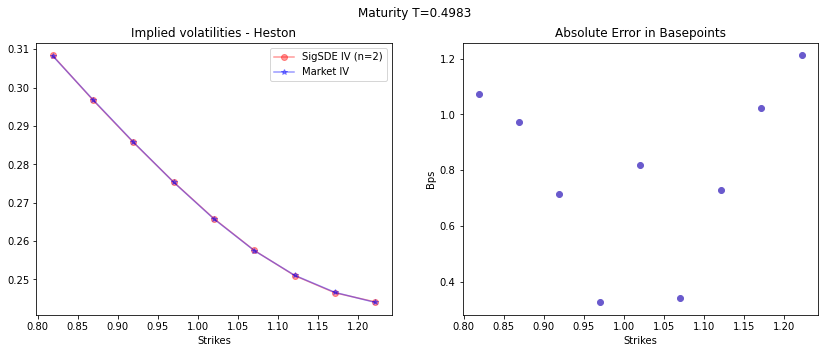

In [175]:
iv_calib_arr_mc_slice=get_iv_from_calib_onemat(calibrated_prices,strikes,maturities[J],J,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[J],4)))
ax1.plot(strikes[J], iv_calib_arr_mc_slice,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[J], iv[J],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[J],np.abs( iv_calib_arr_mc_slice-iv[J])*10000,color='slateblue') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_MC_TV2(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=500)
plt.show()

In [176]:
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res2= least_squares(objective_path_lq, l_initial,loss='linear')
    

l_aux=res1['x']+np.random.normal(0,0.001,dim)



  0%|          | 0/1 [00:00<?, ?it/s]

In [187]:
for t in tqdm(range(1)):
    sol_mix2= least_squares(objective_mix_lq, l_initial,loss='linear')

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!


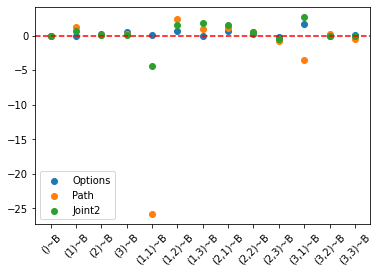

One optimization step completed!
Loss of the mixed problem with the joint param2: 4.55470682234532e-07
One optimization step completed!
Loss of the mixed problem with path param: 0.009513957106689142
One optimization step completed!
Loss of the mixed problem with option param: 0.05556620875035531


In [188]:
plt.scatter(new_keys_B,res1['x'],label='Options')
plt.scatter(new_keys_B,res2['x'],label='Path')
plt.scatter(new_keys_B,sol_mix2['x'],label='Joint2')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

print('Loss of the mixed problem with the joint param2:',np.sum((objective_mix_lq(sol_mix2['x']))**2))
print('Loss of the mixed problem with path param:',np.sum((objective_mix_lq(res1['x']))**2))
print('Loss of the mixed problem with option param:',np.sum((objective_mix_lq(res2['x']))**2))


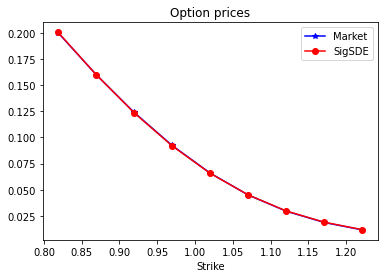

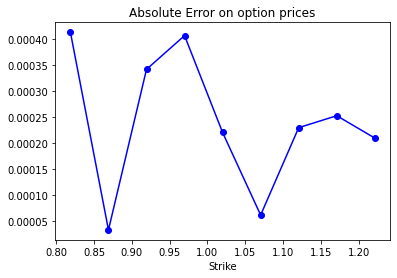

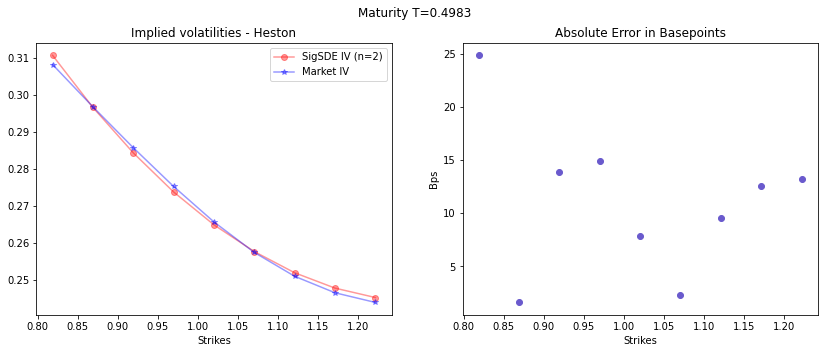

In [189]:

tensor_sigsde_at_mat_MIX3=time_varying_model2(sol_mix2['x'],index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices_MIX3=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat_MIX3,index_sel_maturities,strikes)
j=J
plt.plot(strikes[j],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[j],calibrated_prices_MIX3,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[j],np.abs(Premium1-calibrated_prices_MIX3),marker='o',color='b')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()

j=J
iv_calib_arr_mc_slice_MIX3=get_iv_from_calib_onemat(calibrated_prices_MIX3,strikes,maturities[j],j,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
ax1.plot(strikes[j], iv_calib_arr_mc_slice_MIX3,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[j], iv[j],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[j],np.abs( iv_calib_arr_mc_slice_MIX3-iv[j])*10000,color='slateblue') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_HE_joint(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=250)
plt.show()

In [190]:
iv_calibrated.append(iv_calib_arr_mc_slice_MIX3)

In [191]:
set_calibrated_params.append(sol_mix2['x'])

# Fifth maturity

In [192]:

J=4
T=maturities[J]
T_1=maturities[J-1]
T_2=maturities[J-2]
T_3=maturities[J-3]
T_4=maturities[J-4]

trunc_4=int(T_4*365.25)
trunc_3=int(T_3*365.25)
trunc_2=int(T_2*365.25)
trunc_1=int(T_1*365.25)
trunc=int(T*365.25)

print(trunc)
print(trunc_1)
print(trunc_2)
print(trunc_3)
print(trunc_4)

361
182
91
63
31


In [193]:
noises_x=pc.augment_noises(B_daily_ext,W_daily_ext) #x is the extrapolated one
Sig_data_frame_x, keys, Sig_x=pc.build_Sig_data_frame_sv(order_Signature,noises_x,trunc,comp_of_path,time_days)
transformed_df_x, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_x,new_tilde,keys,comp_of_path,rho,order_Signature)

In [194]:
adjustment_4=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_4]

adjustment_3=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_3]

adjustment_2=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_2]

adjustment_1=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_1]

first_param=np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])

price_path=X_daily[:trunc]


print(adjustment_1.shape)
print(adjustment_2.shape)
print(adjustment_3.shape)
print(adjustment_4.shape)
print(first_param.shape)
print(price_path.shape)


(361, 13)
(361, 13)
(361, 13)
(361, 13)
(361,)
(361,)


In [195]:
def objective_path_lq(l):
    np_dot_4=np.dot(adjustment_4,set_calibrated_params[3])
    np_dot_3=np.dot(adjustment_3,set_calibrated_params[2])
    np_dot_2=np.dot(adjustment_2,set_calibrated_params[1])
    
    diff = np.dot(adjustment_1,l)+np_dot_4+np_dot_3+np_dot_2+first_param+price_path[0] - price_path
    return diff


sel_maturities=[maturities[J]]
index_sel_maturities=[J]

Vega_W=np.array([np.split(flat_normal_weights,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
Premium1=np.array([np.split(prices,len(maturities))[idx] for idx in index_sel_maturities]).flatten()

j=J
arr_dfs_by_mat_swap=np.swapaxes(arr_dfs_by_mat,0,1)

adjusted_arr_dfs=[arr_dfs_by_mat_swap[:,j,:]-arr_dfs_by_mat_swap[:,idx,:] for idx in range(0,j-1)]
adjusted_arr_dfs.insert(0,arr_dfs_by_mat_swap[:,j,:])
adjusted_arr_dfs=np.array(adjusted_arr_dfs)
arr_dfs_to_optimize=arr_dfs_by_mat_swap[:,j,:]-arr_dfs_by_mat_swap[:,j-1,:]
adjusted_scalar_products=np.array([np.tensordot(adjusted_arr_dfs[k],set_calibrated_params[k],axes=1) for k in range(j)])
adjusted_scalar_products=adjusted_scalar_products.transpose()

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

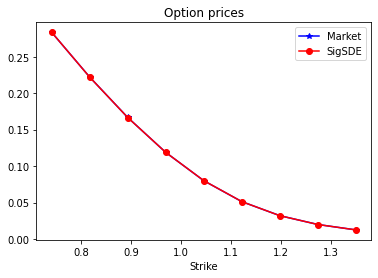

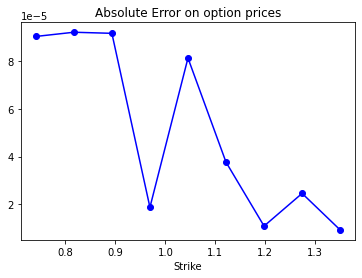

In [196]:
def objective_options(l):
    tensor_sigsde=time_varying_model2(l,index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)
    mc_payoff_arr=get_mc_sel_mat_tensor_TV(tensor_sigsde,index_sel_maturities,strikes)  
    print('One optimization step completed!')
    return np.sqrt(Vega_W)*(mc_payoff_arr-Premium1)


for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res1 = least_squares(objective_options, l_initial,loss='linear')

tensor_sigsde_at_mat=time_varying_model2(res1['x'],index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat,index_sel_maturities,strikes)

plt.plot(strikes[J],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[J],calibrated_prices,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[J],np.abs(Premium1-calibrated_prices),marker='o',color='b')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()


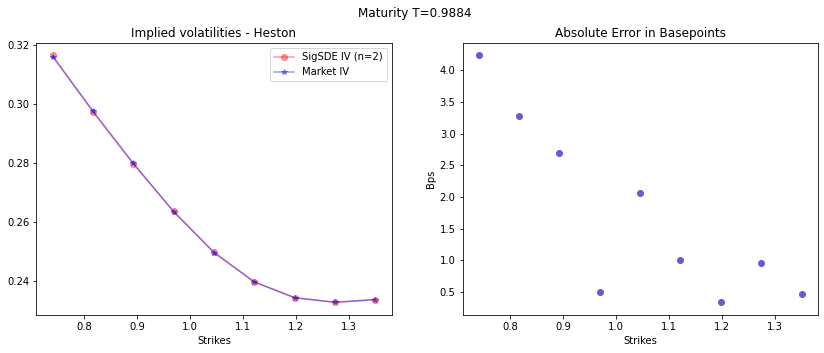

In [208]:
lambd=0.9999
def objective_mix_lq(l):
    conc_=np.concatenate([np.sqrt(1-lambd)*objective_path_lq(l),np.sqrt(lambd)*objective_options(l)],axis=0)
    return conc_
    

iv_calib_arr_mc_slice=get_iv_from_calib_onemat(calibrated_prices,strikes,maturities[J],J,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[J],4)))
ax1.plot(strikes[J], iv_calib_arr_mc_slice,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[J], iv[J],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[J],np.abs( iv_calib_arr_mc_slice-iv[J])*10000,color='slateblue') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_MC_TV2(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=500)
plt.show()


In [209]:
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,dim)
    res2= least_squares(objective_path_lq, l_initial,loss='linear')
    

l_aux=res1['x']+np.random.normal(0,0.001,dim)

for t in tqdm(range(1)):
    sol_mix2= least_squares(objective_mix_lq, l_initial,loss='linear')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimization step completed!
One optimi

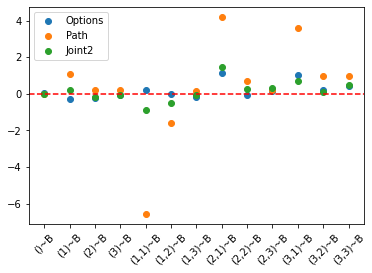

One optimization step completed!
Loss of the mixed problem with the joint param2: 5.585020268318803e-07
One optimization step completed!
Loss of the mixed problem with path param: 0.0006522122761642073
One optimization step completed!
Loss of the mixed problem with option param: 0.08802124785789496


In [210]:


plt.scatter(new_keys_B,res1['x'],label='Options')
plt.scatter(new_keys_B,res2['x'],label='Path')
plt.scatter(new_keys_B,sol_mix2['x'],label='Joint2')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

print('Loss of the mixed problem with the joint param2:',np.sum((objective_mix_lq(sol_mix2['x']))**2))
print('Loss of the mixed problem with path param:',np.sum((objective_mix_lq(res1['x']))**2))
print('Loss of the mixed problem with option param:',np.sum((objective_mix_lq(res2['x']))**2))


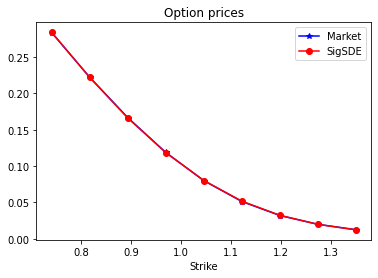

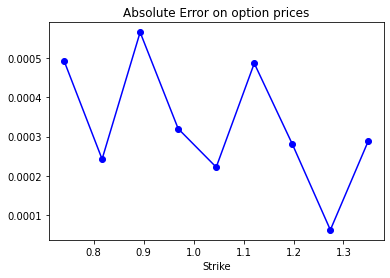

In [211]:


tensor_sigsde_at_mat_MIX3=time_varying_model2(sol_mix2['x'],index_sel_maturities,arr_dfs_to_optimize,adjusted_scalar_products,arr_dfs_by_mat,S0)   
calibrated_prices_MIX3=get_mc_sel_mat_tensor_TV(tensor_sigsde_at_mat_MIX3,index_sel_maturities,strikes)
j=J
plt.plot(strikes[j],Premium1,marker='*',color='b',label='Market')
plt.plot(strikes[j],calibrated_prices_MIX3,marker='o',color='r',label='SigSDE')
plt.legend()
plt.xlabel('Strike')
#plt.ylabel('Price')
plt.title('Option prices')
plt.show()

plt.plot(strikes[j],np.abs(Premium1-calibrated_prices_MIX3),marker='o',color='b')
plt.title('Absolute Error on option prices')
plt.xlabel('Strike')
plt.show()


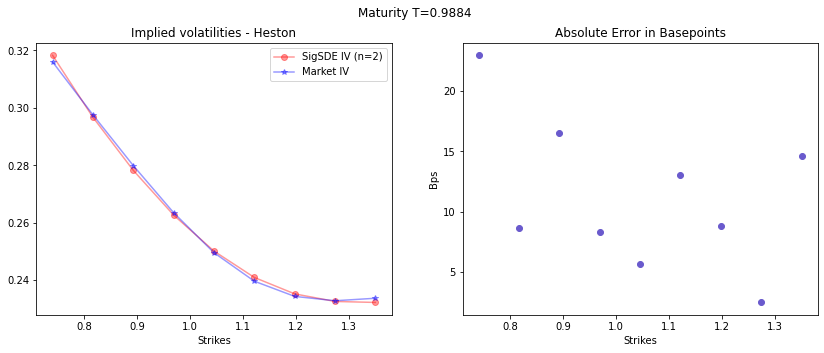

In [212]:


j=J
iv_calib_arr_mc_slice_MIX3=get_iv_from_calib_onemat(calibrated_prices_MIX3,strikes,maturities[j],j,S0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
ax1.plot(strikes[j], iv_calib_arr_mc_slice_MIX3,marker='o',color='r',alpha=0.4,label=f'SigSDE IV (n={n})')
ax1.plot(strikes[j], iv[j],marker='*',alpha=0.4,color='b',label='Market IV')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities - Heston')
ax2.scatter(strikes[j],np.abs( iv_calib_arr_mc_slice_MIX3-iv[j])*10000,color='slateblue') 
ax2.set_xlabel('Strikes')
ax2.set_ylabel('Bps')
ax2.set_title('Absolute Error in Basepoints')
ax1.legend()
#plt.savefig('Fit_HE_joint(T={}'.format(round(maturities[j],4))+', with n=2).png',dpi=250)
plt.show()

#

In [276]:
iv_calib_arr_mc_slice_MIX3

array([0.31827624, 0.29670992, 0.27825037, 0.26267787, 0.25015058,
       0.240977  , 0.23526278, 0.2326228 , 0.23227809])

In [213]:
iv_calibrated.append(iv_calib_arr_mc_slice_MIX3)

In [220]:
set_calibrated_params.append(sol_mix2['x'])

In [215]:
len(set_calibrated_params)

6

In [217]:
set_calibrated_params=set_calibrated_params[:4]

In [221]:
set_calibrated_params

[array([  0.28179918,  -0.11303432,   0.10068262,   0.28012039,
         28.98202039,  -4.92171831, -15.96193714,  -0.31238619,
         -1.23353391,  -1.90500263,   5.38365715,  -0.71064391,
         -2.34872348]),
 array([ 1.37435321e-02, -1.05861589e+00, -6.41754127e-04, -6.88228938e-02,
        -2.56218987e+01,  5.32471414e+00,  1.27688864e+01, -5.87256271e+00,
         9.72697870e-01,  2.30905259e+00, -1.63927796e+01,  8.45634748e-01,
         1.17042294e+00]),
 array([ 4.43638146e-03,  1.85092271e-01, -7.19294523e-02, -2.69021649e-01,
         2.11450618e-01, -1.83541172e+00,  2.38942594e+00,  3.84742689e+00,
        -3.43581989e-01, -2.92116189e-01,  7.03239041e+00, -1.33521387e-01,
         7.60385789e-01]),
 array([-0.01574576,  0.64709395, -0.02820456,  0.15924963, -2.84900704,
         2.27080513,  1.05501468,  0.95077011,  0.30168126, -0.35635241,
         2.8881719 , -0.25621438, -0.07486889]),
 array([-0.0225636 ,  0.21972951, -0.18461062, -0.07670227, -0.90571851,
      

In [278]:
iv_calibrated=iv_calibrated[:4]
iv_calibrated.append(iv_calib_arr_mc_slice_MIX3)

# <font color='darkblue'> Display the results </font>

In [222]:

J=4
T=maturities[J]
T_1=maturities[J-1]
T_2=maturities[J-2]
T_3=maturities[J-3]
T_4=maturities[J-4]

trunc_4=int(T_4*365.25)
trunc_3=int(T_3*365.25)
trunc_2=int(T_2*365.25)
trunc_1=int(T_1*365.25)
trunc=int(T*365.25)

print(trunc)
print(trunc_1)
print(trunc_2)
print(trunc_3)
print(trunc_4)

noises_x=pc.augment_noises(B_daily_ext,W_daily_ext) #x is the extrapolated one
Sig_data_frame_x, keys, Sig_x=pc.build_Sig_data_frame_sv(order_Signature,noises_x,len(time_days),comp_of_path,time_days)
transformed_df_x, new_keys_B=pc.transform_data_frame_sv(Sig_data_frame_x,new_tilde,keys,comp_of_path,rho,order_Signature)

adjustment_4=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_4]

adjustment_3=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_3]

adjustment_2=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_2]

adjustment_1=transformed_df_x[new_keys_B]-transformed_df_x[new_keys_B].iloc[trunc_1]

first_param=np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])

price_path=X_daily[:len(time_days)]


print(adjustment_1.shape)
print(adjustment_2.shape)
print(adjustment_3.shape)
print(adjustment_4.shape)
print(first_param.shape)
print(price_path.shape)



361
182
91
63
31
(721, 13)
(721, 13)
(721, 13)
(721, 13)
(721,)
(721,)


In [223]:
trunc_1

182

In [224]:
first_param.shape

(721,)

In [225]:
first_param=(np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])+1)[:trunc_4]

In [226]:
second_param=(np.dot(adjustment_4,set_calibrated_params[1])+np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])+1)[trunc_4:trunc_3]

In [227]:
third_param=(np.dot(adjustment_3,set_calibrated_params[2])+np.dot(adjustment_4,set_calibrated_params[1])+np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])+1)[trunc_3:trunc_2]

In [228]:
fourth_param=(np.dot(adjustment_2,set_calibrated_params[3])+np.dot(adjustment_3,set_calibrated_params[2])+np.dot(adjustment_4,set_calibrated_params[1])+np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])+1)[trunc_2:trunc_1]

In [229]:
fifth_param=(np.dot(adjustment_1,set_calibrated_params[4])+np.dot(adjustment_2,set_calibrated_params[3])+np.dot(adjustment_3,set_calibrated_params[2])+np.dot(adjustment_4,set_calibrated_params[1])+np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])+1)[trunc_1:trunc]

In [386]:
window=360

In [387]:
final_param=(np.dot(adjustment_1,set_calibrated_params[4])+np.dot(adjustment_2,set_calibrated_params[3])+np.dot(adjustment_3,set_calibrated_params[2])+np.dot(adjustment_4,set_calibrated_params[1])+np.dot(transformed_df_x[new_keys_B],set_calibrated_params[0])+1)[trunc:trunc+window]

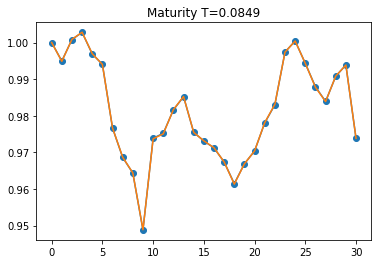

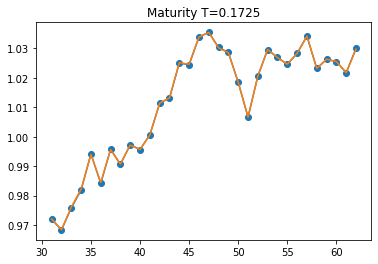

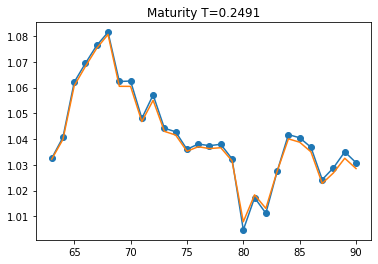

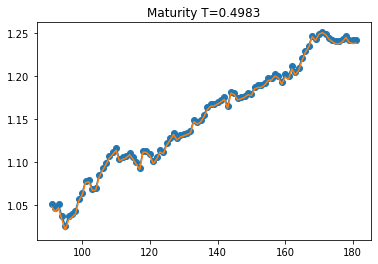

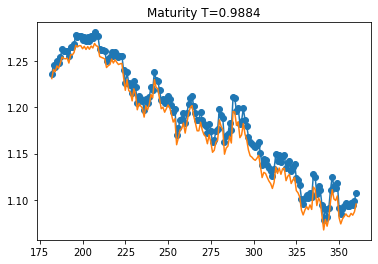

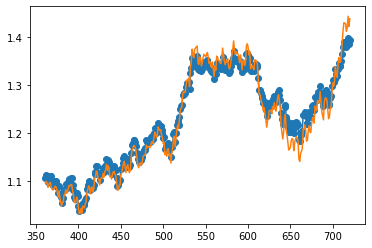

In [27]:
%matplotlib inline
plt.plot(range(trunc_4),first_param,marker='o')
plt.plot(range(trunc_4),X_daily[:trunc_4])
plt.title('Maturity T={}'.format(round(maturities[0],4)))
plt.show()
plt.plot(range(trunc_4,trunc_3),second_param,marker='o')
plt.plot(range(trunc_4,trunc_3),X_daily[trunc_4:trunc_3])
plt.title('Maturity T={}'.format(round(maturities[1],4)))
plt.show()
plt.plot(range(trunc_3,trunc_2),third_param,marker='o')
plt.plot(range(trunc_3,trunc_2),X_daily[trunc_3:trunc_2])
plt.title('Maturity T={}'.format(round(maturities[2],4)))
plt.show()
plt.plot(range(trunc_2,trunc_1),fourth_param,marker='o')
plt.plot(range(trunc_2,trunc_1),X_daily[trunc_2:trunc_1])
plt.title('Maturity T={}'.format(round(maturities[3],4)))
plt.show()
plt.plot(range(trunc_1,trunc),fifth_param,marker='o')
plt.plot(range(trunc_1,trunc),X_daily[trunc_1:trunc])
plt.title('Maturity T={}'.format(round(maturities[4],4)))
plt.show()
plt.plot(range(trunc,trunc+window),final_param,marker='o')
plt.plot(range(trunc,trunc+window),X_daily[trunc:trunc+window])
plt.show()

In [28]:
trunc

361

In [29]:
days

721

In [30]:
sig_sde_traj=np.concatenate([first_param,second_param,third_param,fourth_param,fifth_param,final_param],axis=0)

In [31]:
from bokeh.models import Legend
import os

In [4]:
os.chdir(r'C:\\Users\\Guido Gazzani\\ucloud\\Shared\\SigSDEs_ucloud\\Code_joint_calibration\\replicate_correct_plots\\may')
os.getcwd()

'C:\\Users\\Guido Gazzani\\ucloud\\Shared\\SigSDEs_ucloud\\Code_joint_calibration\\replicate_correct_plots\\may'

In [34]:
sig_sde_traj=np.load('sig_sde_traj.npy')
X_daily=np.load('X_daily.npy')
window=360
trunc=361
days=window+trunc

In [35]:
window

360

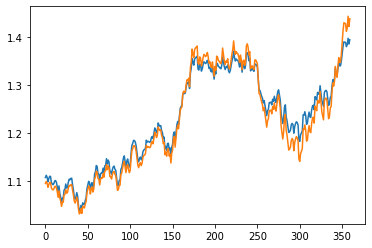

In [36]:
plt.plot(sig_sde_traj[trunc:trunc+ww])
plt.plot(X_daily[trunc:trunc+ww])

In [38]:
ww=window
q = figure(width=800, height=490,title='Path calibration')
q1 = q.line(np.linspace(0,2,days)[:trunc+ww],sig_sde_traj[:trunc+ww], line_color='royalblue')
q4 = q.scatter(np.linspace(0,2,days)[:trunc+ww],sig_sde_traj[:trunc+ww], color='royalblue',size=3)
q2 = q.line(np.linspace(0,2,days)[:trunc+ww],X_daily[:trunc+ww], line_color='tomato')
q3= q.line([np.linspace(0,2,days)[trunc],np.linspace(0,2,721)[trunc]], [min(sig_sde_traj[:trunc+ww]),max(sig_sde_traj[:trunc+ww])], line_width=1,line_color='orange',line_dash='dashed')


legend = Legend(items=[
    ("Sig-SDE",   [q1]),
    ("Heston",[q2])
], location=(-620,360))

q.add_layout(legend, 'right')
show(q)


In [39]:
mean_squared_error(sig_sde_traj[trunc:trunc+ww],X_daily[trunc:trunc+ww]) #out of sample

0.0002844848128693271

In [40]:
mean_squared_error(sig_sde_traj[:trunc],X_daily[:trunc]) # in sample

6.544870588406172e-05

In [423]:
os.getcwd()

'C:\\Users\\Guido Gazzani\\ucloud\\Shared\\SigSDEs_ucloud\\Code_joint_calibration\\replicate_correct_plots\\may'

In [265]:
YY=np.array([[maturities[j]]*(len(strikes[0])) for j in range(5)])


In [269]:
from matplotlib.pyplot import cm

<IPython.core.display.Javascript object>


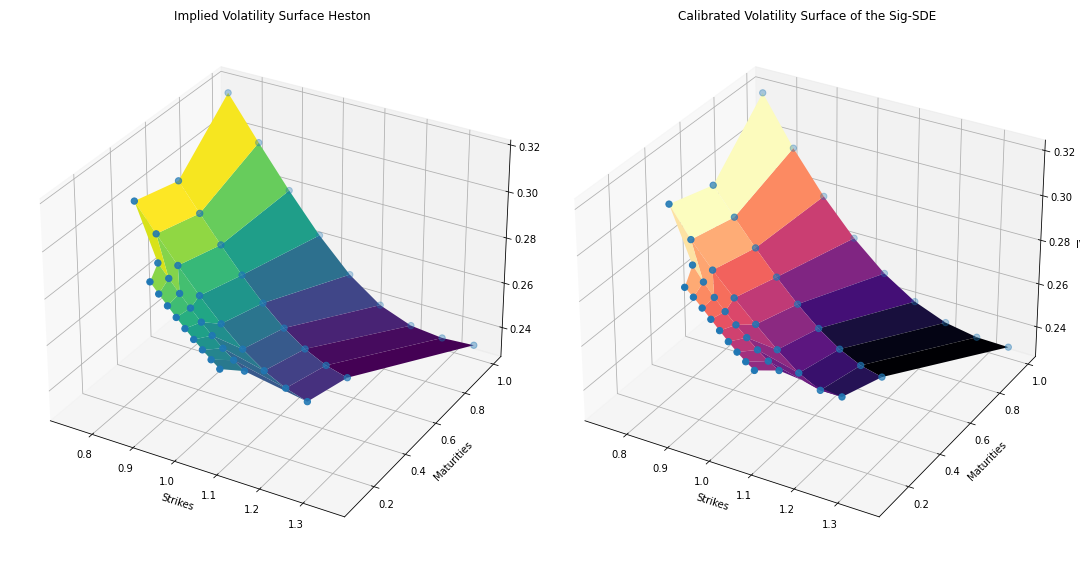

In [280]:
%matplotlib notebook

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf = ax.plot_surface(strikes[:5,:], YY, iv[:5], rstride=1, cstride=1, cmap=cm.viridis,
                       linewidth=0.5)

surf = ax.scatter(strikes[:5,:], YY, iv[:5],s=40)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
#ax.set_zlabel('IV')
ax.set_title('Implied Volatility Surface Heston');
#ax.set_zlim(-1.01, 1.01)
#fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_surface(strikes[:5,:], YY, np.array(iv_calibrated), rstride=1, cstride=1,cmap=cm.magma,
                       linewidth=0.5)
ax.scatter(strikes[:5,:], YY, np.array(iv_calibrated),s=40)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')
ax.set_title('Calibrated Volatility Surface of the Sig-SDE');
#plt.savefig('IV_surface_comparison3.png',dpi=500)

plt.tight_layout()
plt.show()

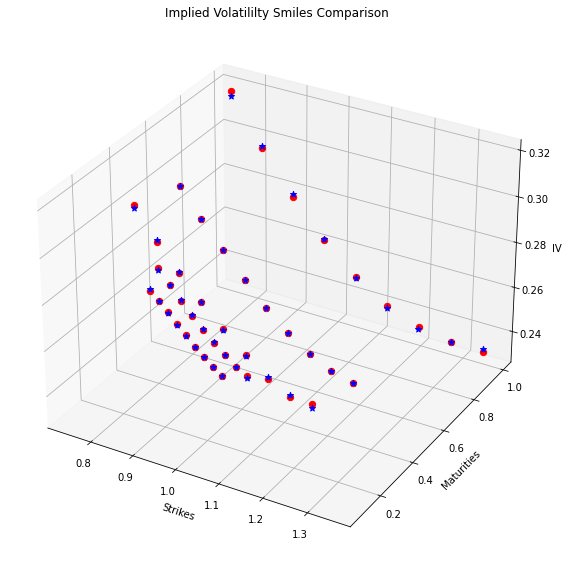

In [403]:
%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')


ax.scatter(strikes[:5,:], YY, np.abs(np.array(iv_calibrated)),s=40,c='red',marker='o',depthshade=False)
ax.scatter(strikes[:5,:], YY, np.abs(iv[:5]),s=40,c='blue',marker='*',depthshade=False)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')
ax.set_title('Implied Volatililty Smiles Comparison');
plt.savefig('IV_surface_only_points_joint.png',dpi=200)

plt.tight_layout()
plt.show()

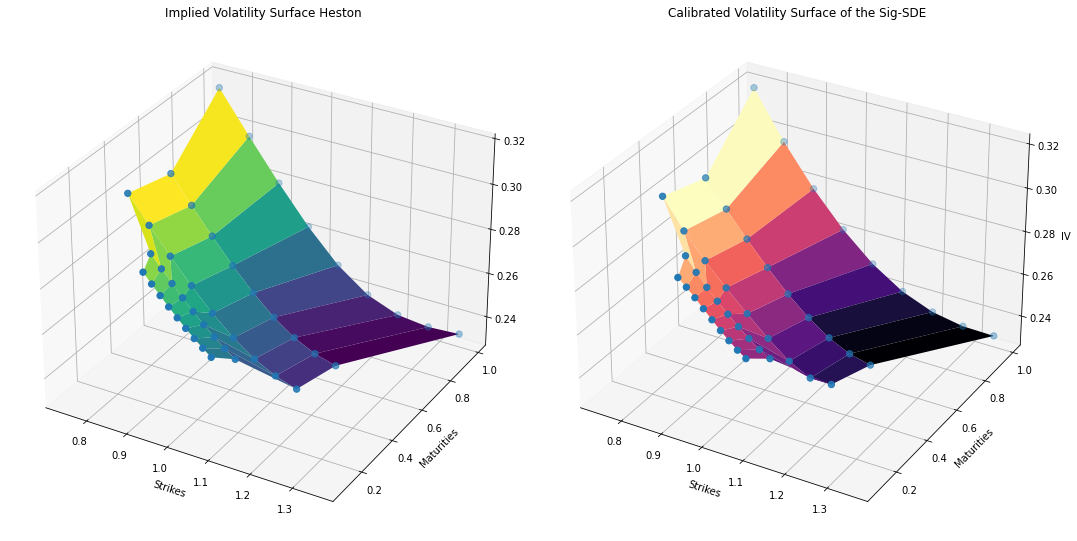

In [357]:
%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf = ax.plot_surface(strikes[:5,:], YY, iv[:5], rstride=1, cstride=1, cmap=cm.viridis,
                       linewidth=0.5)

surf = ax.scatter(strikes[:5,:], YY, iv[:5],s=40)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
#ax.set_zlabel('IV')
ax.set_title('Implied Volatility Surface Heston');
#ax.set_zlim(-1.01, 1.01)
#fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_surface(strikes[:5,:], YY, np.array(iv_calibrated), rstride=1, cstride=1,cmap=cm.magma,
                       linewidth=0.5)
ax.scatter(strikes[:5,:], YY, np.array(iv_calibrated),s=40)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')
ax.set_title('Calibrated Volatility Surface of the Sig-SDE');
plt.savefig('IV_surface_comparison_joint_both.png',dpi=200)

plt.tight_layout()
plt.show()

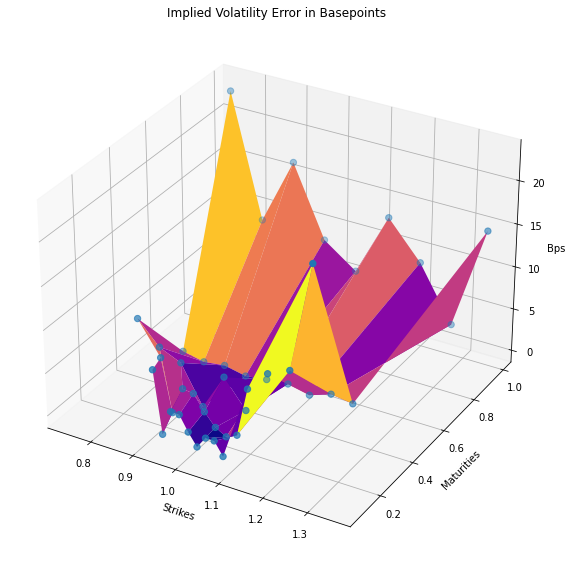

In [399]:
%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_surface(strikes[:5,:], YY, np.abs(np.array(iv_calibrated)-iv[:5])*10000, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0.5)
ax.scatter(strikes[:5,:], YY, np.abs(np.array(iv_calibrated)-iv[:5])*10000,s=40)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Bps')
ax.set_title('Implied Volatility Error in Basepoints');
plt.savefig('IV_surface_comparison_joint.png',dpi=150)

plt.tight_layout()
plt.show()

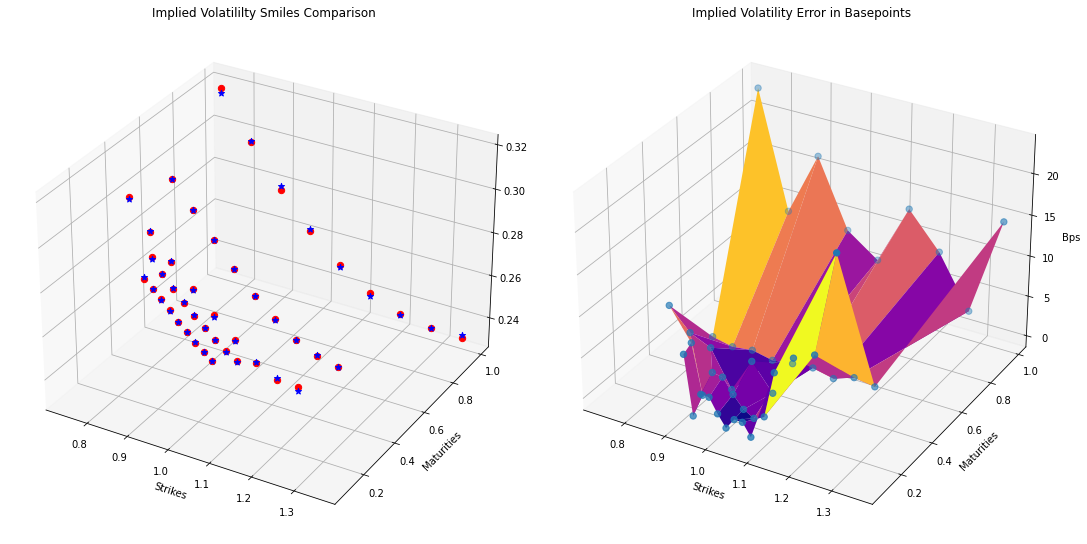

In [408]:
%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

#surf = ax.plot_surface(strikes, YY, iv_market, rstride=1, cstride=1, cmap=cm.viridis,
#                       linewidth=0.5)

ax.scatter(strikes[:5,:], YY, np.abs(np.array(iv_calibrated)),s=40,c='red',marker='o',depthshade=False)
ax.scatter(strikes[:5,:], YY, np.abs(iv[:5]),s=40,c='blue',marker='*',depthshade=False)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
#ax.set_zlabel('IV')
ax.set_title('Implied Volatililty Smiles Comparison');

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_surface(strikes[:5,:], YY, np.abs(np.array(iv_calibrated)-iv[:5])*10000, rstride=1, cstride=1,cmap=cm.plasma,
                       linewidth=0.5)
ax.scatter(strikes[:5,:], YY, np.abs(np.array(iv_calibrated)-iv[:5])*10000,s=40)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Bps')
ax.set_title('Implied Volatility Error in Basepoints');

plt.savefig('IV_surface_jointcalibration.png',dpi=150)
plt.tight_layout()
plt.show()

In [354]:
os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_joint_calibration\replicate_correct_plots\may')

In [361]:
np.save('iv_calibrated.npy',iv_calibrated)
np.save('iv.npy',iv[:5])
np.save('set_calibrated_params.npy',np.array(set_calibrated_params))
np.save('sig_sde_traj.npy',sig_sde_traj)

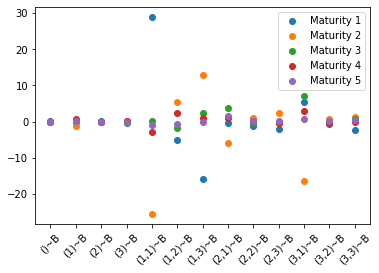

In [400]:
i=1
for j in set_calibrated_params:
    plt.scatter(new_keys_B,j,label='Maturity '+str(i))
    plt.xticks(rotation=45)
    i=i+1
plt.legend()
plt.show()